# NER result analysis, field *fund_name*

In [10]:
import pandas as pd
from ast import literal_eval
import seaborn as sns
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from Levenshtein._levenshtein import distance

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [11]:
result = pd.read_csv('./result.csv', sep='///', index_col=False, error_bad_lines=False)
result.proba_dict = result.proba_dict.apply(literal_eval)
result.head()

/Users/samos/.conda/envs/Sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,found,gt,prediction,proba_dict
0,True,cogefi europe,cogefi europe,"{'cogefi europe': [1.0, 0.946, 0.054, 1.0, 1.0..."
1,True,slgp valeurope,slgp valeurope,"{'swiss life gestion privee': [1.0, 0.497, 1.0..."
2,True,lazard patrimoine pea,lazard patrimoine pea,"{'lazard patrimoine pea': [1.0, 1.0, 1.0, 1.0,..."
3,True,slgp short bonds,slgp short bonds,"{'swiss life gestion privee': [1.0, 0.497, 1.0..."
4,True,allianz multi equilibre,allianz multi equilibre,"{'allianz multi': [0.999, 0.001], 'equilibre':..."


In [12]:
print('Sample Accuracy:', round(result.found.mean()*100, 2))

Sample Accuracy: 82.44


In [13]:
print(result.head()[['found', 'gt', 'prediction']].to_markdown())

AttributeError: 'DataFrame' object has no attribute 'to_markdown'

In [14]:
print(result.head()[['found', 'gt', 'prediction']].to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>found</th>
      <th>gt</th>
      <th>prediction</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>True</td>
      <td>cogefi europe</td>
      <td>cogefi europe</td>
    </tr>
    <tr>
      <th>1</th>
      <td>True</td>
      <td>slgp valeurope</td>
      <td>slgp valeurope</td>
    </tr>
    <tr>
      <th>2</th>
      <td>True</td>
      <td>lazard patrimoine pea</td>
      <td>lazard patrimoine pea</td>
    </tr>
    <tr>
      <th>3</th>
      <td>True</td>
      <td>slgp short bonds</td>
      <td>slgp short bonds</td>
    </tr>
    <tr>
      <th>4</th>
      <td>True</td>
      <td>allianz multi equilibre</td>
      <td>allianz multi equilibre</td>
    </tr>
  </tbody>
</table>


|    | found   | ground truth            | prediction              |
|---:|:--------|:------------------------|:------------------------|
|  0 | True    | atomic ionization       | atomic ionization       |
|  1 | False   | kinetics of germination | kinetics of germinations|
|  2 | True    | infrared image synthesis| infrared image synthesis|
|  3 | False   | quantum brakes          | quantum brakes of       |
|  4 | False   | matter waves            | probability amplitudes  |

### Let's have a look at the raw proba results.

### It is for each prospectus a dictionnary with the list of probabilities associated to a key.

In [15]:
result.proba_dict[10]

{'oddo bhf investissement': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.942,
  0.058,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'actions internationales': [0.091, 0.091, 0.091],
 'externes lorsque': [1.0, 1.0, 1.0],
 'cedex 09 france': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'etait msci world': [1.0, 1.0, 1.0],
 'oddo bhf sca': [0.897, 0.103, 0.897, 0.103, 0.897, 0.103, 1.0, 1.0],
 'oddo bhf': [0.103, 0.103, 0.103, 0.003, 0.78, 0.78, 0.22, 1.0, 0.004],
 'informations cles': [1.0, 1.0],
 'gc eur': [0.0, 0.232],
 'cn eur': [1.0, 1.0],
 'etat m emb re': [1.0],
 '100 euros': [1.0],
 'societe': [0.003],
 'adresse': [0.0],
 'oddo bhf asset': [0.001, 0.22, 1.0, 0.001],
 'http://am.oddo bhf.com': [0.992, 0.007, 0.001, 0.942, 0.058],
 'service clients': [0.992, 0.007, 0.001, 0.0],
 '44 51 80 28': [0.992, 0.942, 0.058],
 '51 80 28': [0.001],
 'oddo bhf sca assure': [0.78, 0.22],
 'european fund administ

### Let's compute the normalized sum of those proba to get a confidence level of the predicted field.

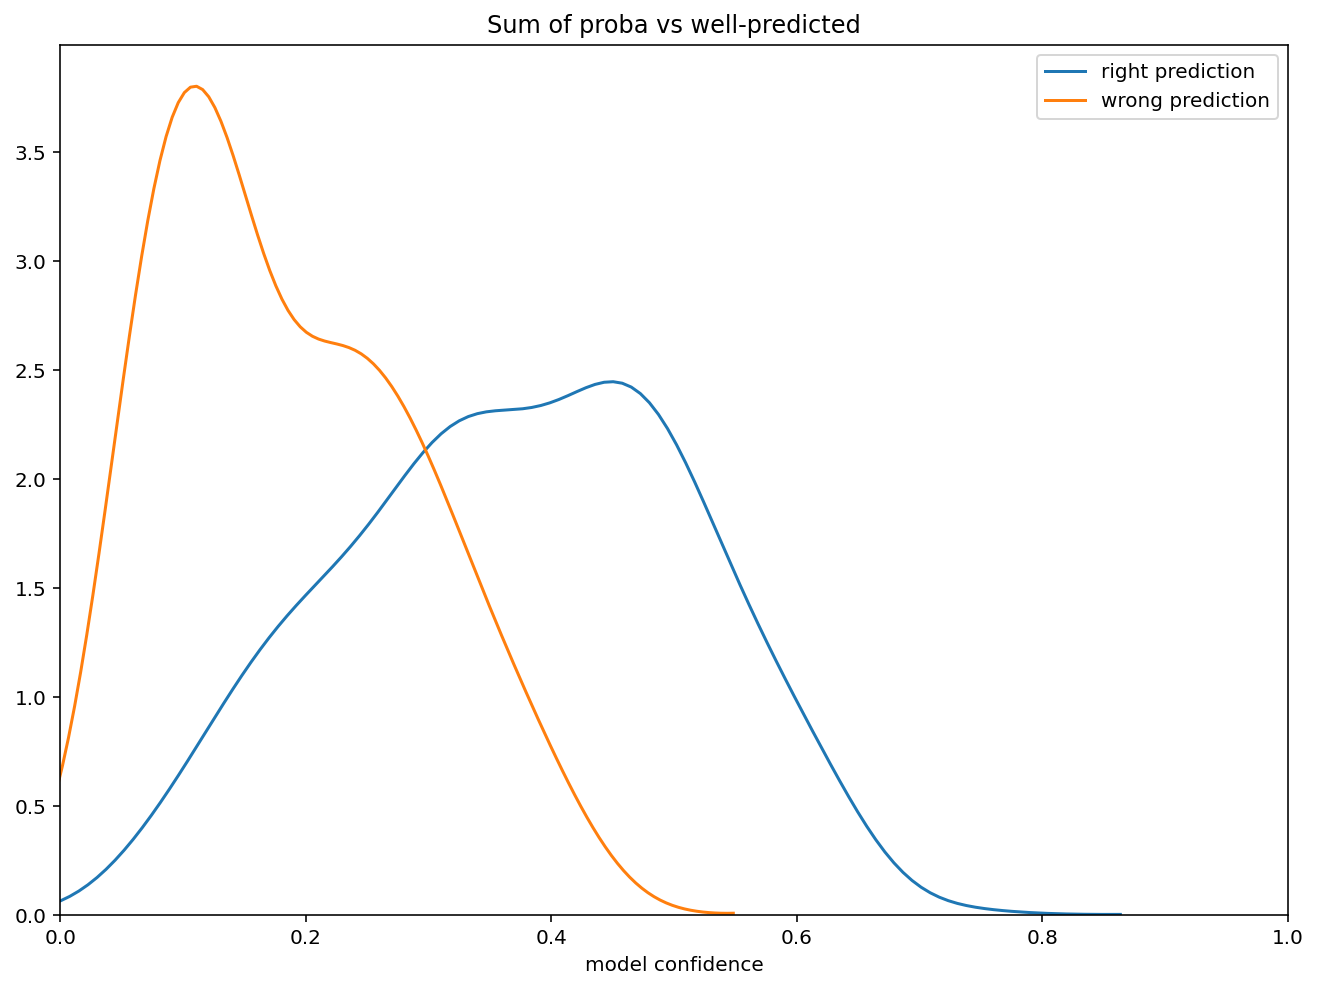

In [16]:
result['sum_proba'] = result['proba_dict'].apply(lambda x: {k: sum(v) for k, v in x.items()})
result['sum_proba'] = result['sum_proba'].apply(
    lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
)
result['sum_proba_normalized'] = result['sum_proba'].apply(
    lambda x: {k: v / sum(x.values()) for k, v in x.items()}
)
result['model confidence'] = result['sum_proba_normalized'].apply(lambda x: list(x.values())[0])
result['max_sum_proba'] = result['sum_proba_normalized'].apply(lambda x: list(x.values())[0])

plt.figure(figsize=(11, 8))
sns.distplot(result[result.found == True]['model confidence'], hist=False, label='right prediction', norm_hist=True)
sns.distplot(result[result.found == False]['model confidence'], hist=False, label='wrong prediction', norm_hist=True)
plt.xlim(0, 1)
plt.title('Sum of proba vs well-predicted')
plt.show()

### When we plot the confidence distribution vs. the label (true is when prediction is good and false when it's not), we remark a strong correlation: for confidence > 0.4 there is a 99% chance that the predicted field is right.

In [17]:
print('Accuracy for confidence > 0.4:', round(result[result.max_sum_proba > .4].found.mean()*100, 2))

Accuracy for confidence > 0.4: 98.96


### On the sample below we see that the lowest confidence returns a wrong prediction.

In [7]:
result.tail()

,found,gt,prediction,proba_dict,sum_proba,sum_proba_normalized,model confidence,max_sum_proba
519,True,hsbc select equity,hsbc select equity,"{'hsbc select equity': [1.0, 1.0, 1.0, 1.0, 1....","{'hsbc select equity': 36.0, 'hsbc global asse...","{'hsbc select equity': 0.3904428272398945, 'hs...",0.390443,0.390443
520,True,r co conviction credit 12m euro,r co conviction credit 12m euro,"{'conviction credit 12m euro': [0.996, 0.004, ...",{'r co conviction credit 12m euro': 22.2980000...,{'r co conviction credit 12m euro': 0.24869229...,0.248692,0.248692
521,False,loxodonta,sg 29 haussmann,"{'loxodonta ': [1.0, 1.0, 1.0], 'sg 29 haussma...","{'sg 29 haussmann': 5.999, 'loxodonta ': 3.0, ...","{'sg 29 haussmann': 0.2175915850562205, 'loxod...",0.217592,0.217592
522,True,oddo bhf partage,oddo bhf partage,"{'oddo bhf partage': [1.0, 1.0, 1.0, 1.0, 1.0,...","{'oddo bhf partage': 30.0, 'oddo bhf sca': 6.3...","{'oddo bhf partage': 0.3709978605790039, 'oddo...",0.370998,0.370998
523,True,afer marches emergents,afer marches emergents,"{'afer marches': [1.0], 'fevrier 2020': [1.0],...","{'afer marches emergents': 23.0, 'aviva invest...","{'afer marches emergents': 0.2936332648189049,...",0.293633,0.293633


### Let's focus on a wrong prediction:

In [8]:
result.loc[[521], ['found', 'gt', 'prediction']]

,found,gt,prediction
521,False,loxodonta,sg 29 haussmann


In [9]:
result.loc[521, 'sum_proba_normalized']

{'sg 29 haussmann': 0.2175915850562205,
 'loxodonta\n': 0.1088139281828074,
 'loxodonta': 0.07363075807036634,
 'taux bareme': 0.071563293434893,
 'affectation devise': 0.03627130939426913,
 'huit jours': 0.03627130939426913,
 'listees': 0.03627130939426913,
 'courtier principal': 0.03627130939426913,
 'categorie high yield': 0.03627130939426913,
 'instruments utilises': 0.03627130939426913,
 'libellee en euro': 0.03627130939426913,
 'sg 29 haussmann etablit': 0.03627130939426913,
 'sg 29 haussmann applique': 0.03627130939426913,
 'article 3': 0.03627130939426913,
 'sans pouvoir exceder': 0.03627130939426913,
 'article 4': 0.03627130939426913,
 'article 12': 0.03627130939426913,
 'ndeg gp06000029': 0.036271309394269126,
 'sauf delai specifique': 0.009357997823721436,
 'cedex 18': 0.006855277475516866,
 'paris cedex 18': 0.0037359448676097203,
 'sauf delai specifique convenu': 0.0005803409503083062,
 'sg 29': 3.6271309394269135e-05,
 'cedex': 3.6271309394269135e-05,
 'paris cedex': 0.0,

1. The probabilities are low (all < 0.22). As seen previously the model is not confident when there are errors.
2. Second and third found field are the same with a '\n' difference => data cleaning to be enhanced
3. Second field is the good answer

### Let's check how often the second field is the right answer when the first is wrong.

In [10]:
bad_result = result[result.found == False].copy()
bad_result['second_choice_thresholded_proba'] = bad_result.sum_proba_normalized.apply(
    lambda x: list(x.keys())[1])

In [11]:
def f(x):
    pred, gt = x['second_choice_thresholded_proba'], x['gt']
    return True if (distance(pred, gt) < 6 or gt in pred or pred in gt) and pred else False

bad_result.apply(f, axis=1).mean()

0.5

### The previous result shows that in 50% of the case when we're wrong, taking the second choice gives the right answer.

### In a business point of view we could say that answer is found (with 99% confidence) when confidence is >0.4 and propose the two first choices of the model when confidence<0.4

In [12]:
print('Accuracy for confidence < 0.4:', round(result[result.max_sum_proba < .4].found.mean()*100, 2))

Accuracy for confidence < 0.4: 72.89


In [13]:
acc = bad_result[result.max_sum_proba < .4].apply(f, axis=1).mean()
print('Accuracy for second choice when confidence < 0.4:', round(acc*100, 2))

Accuracy for second choice when confidence < 0.4: 48.89


/Users/samos/.conda/envs/Sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [17]:
print('the proportion of confident prediction is:', round((result.max_sum_proba > 0.4).mean()*100, 2))

the proportion of confident prediction is: 36.64


### Overall accuracy with this technic:

(accuracy_confident * proportion_confident) + (accuracy_no_confident + accuracy_second_choice_no_confident * proportion_no_confidence_with_error) * proportion_no_confident

In [19]:
0.99*0.37 + (0.73 + 0.48*(1-0.73))*(1-0.37)

0.907848

### Let's have another look at the errors

In [20]:
result.loc[result.found == False, ['found', 'gt', 'prediction', 'proba_dict']]

,found,gt,prediction,proba_dict
5,False,sanso opportunites,sanso investment solutions,"{'sanso opportunites': [1.0, 1.0, 1.0, 1.0, 1...."
12,False,echiquier value euro,action g,"{'echiquier value euro': [1.0, 1.0, 1.0, 1.0, ..."
16,False,unofi pacifique,19113 brive cedex,"{'unofi pacifique': [1.0, 1.0, 0.868, 0.07, 0...."
26,False,dnca evolutif,vendome 75001 paris,"{'dnca evolutif': [1.0, 1.0, 1.0, 1.0, 1.0], '..."
27,False,gemequity,gemway assets,"{'gemway assets': [0.565, 0.435, 0.57, 0.43, 0..."
...,...,...,...,...
491,False,eurose,vendome 75001 paris,"{'verso': [1.0, 1.0, 1.0], 'fevrier 2020': [1...."
501,False,gfc gestion de fortune,generali investments europe,{'bnmshdms untr rnms entqmhdr bnmenqleldms': [...
504,False,lazard patrimoine opportunities,lazard multi assets,"{'lazard patrimoine': [1.0, 1.0, 1.0, 1.0, 1.0..."
511,False,antenor,faubourg saint honore,"{'affichee demeure inchangee': [0.955, 0.955],..."


### It seems that the first prediction from the pdf is often right (the title aka. *fund_name* is often at the beginning of the doc. Hence it is maybe a better choice than second proba).

In [21]:
threshold_proba = 0.35

def f(x):
    proba_dict, sum_proba = x['proba_dict'], x['sum_proba_normalized']
    return list(sum_proba.keys())[0] if list(sum_proba.values())[0] > threshold_proba else list(proba_dict.keys())[0]

result['first_pred_thresholded_proba'] = result.apply(f, axis=1)

In [22]:
def f(x):
    pred, gt = x['first_pred_thresholded_proba'], x['gt']
    return True if (distance(pred, gt) < 6 or gt in pred or pred in gt) and pred else False

result.apply(f, axis=1).mean()

0.8702290076335878

### We get a 87% accuracy with only one proposed prediction here

### Let's compute the score with a two prediction of two propositions.

In [30]:
print('Accuracy for confidence < 0.35:', round(result[result.max_sum_proba < .35].found.mean()*100, 2))

Accuracy for confidence < 0.35: 69.2


In [35]:
print('Accuracy for confidence > 0.35:', round(result[result.max_sum_proba > .35].found.mean()*100, 2))

Accuracy for confidence > 0.35: 97.18


In [31]:
bad_result = result[result.found == False].copy()
acc = bad_result[result.max_sum_proba < .35].apply(f, axis=1).mean()
print('Accuracy for second choice when confidence < 0.4:', round(acc*100, 2))

Accuracy for second choice when confidence < 0.4: 49.41


/Users/samos/.conda/envs/Sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [33]:
print('the proportion of confident prediction is:', round((result.max_sum_proba > 0.35).mean()*100, 2))

the proportion of confident prediction is: 47.33


### Overall accuracy with this technic:

In [37]:
0.97*0.47 + (0.69 + 0.49*(1-0.69))*(1-0.47)

0.902107

In [45]:
bad_result.loc[[511]]

,found,gt,prediction,proba_dict,sum_proba,sum_proba_normalized,model confidence,max_sum_proba,first_pred_thresholded_proba
511,False,antenor,faubourg saint honore,"{'affichee demeure inchangee': [0.955, 0.955],...","{'faubourg saint honore': 6.0, 'antenor ': 2.0...","{'faubourg saint honore': 0.19814405072487698,...",0.198144,0.198144,affichee demeure inchangee


In [46]:
bad_result.loc[511].sum_proba_normalized

{'faubourg saint honore': 0.19814405072487698,
 'antenor\n': 0.06604801690829233,
 'us person': 0.06604801690829232,
 'service commercial': 0.06601499289983818,
 'affichee demeure inchangee': 0.06307585614741917,
 'antenor\n forme juridique': 0.033024008454146166,
 '100 euros': 0.033024008454146166,
 '1000 euros': 0.033024008454146166,
 'montant minimal': 0.033024008454146166,
 '100 000 euros': 0.033024008454146166,
 'solutions depositaires': 0.033024008454146166,
 'eurostoxx 50': 0.033024008454146166,
 'report total': 0.033024008454146166,
 'indirects maximum': 0.033024008454146166,
 'actions warrants obligations convertibles': 0.033024008454146166,
 'eurex 1,00 EURttc': 0.033024008454146166,
 'article 3': 0.033024008454146166,
 'article 4': 0.033024008454146166,
 'article 12': 0.033024008454146166,
 'souscripteurs sauf': 0.03299098444569202,
 'futures us 2$ttc': 0.03299098444569202,
 'euroclear france': 0.007199233843003864,
 'affichee demeure': 0.0029721607608731546,
 'chaque transa

- Retrain avec weights on missed
- Stack a second model that learn if we must take best, second_best or first prediction

# Other topic: proba calibration

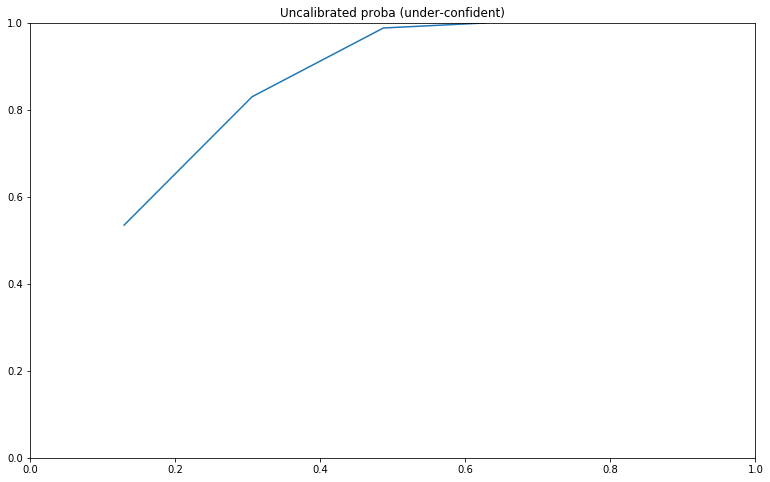

In [331]:
plt.figure(figsize=(13, 8))
fraction_of_positives, mean_predicted_value = calibration_curve(result.found, result.max_sum_proba)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.plot(mean_predicted_value, fraction_of_positives)
plt.title('Uncalibrated proba (under-confident)')
plt.show()